In [1]:
from skimage import draw, io, util
from skimage.measure import approximate_polygon, find_contours
import numpy as np
import json
import os
import glob

In [2]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [3]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return (rmin,rmax+1), (cmin,cmax+1)

In [5]:
data_dir = os.path.join('.','Book of Fortresses','Book of Fortresses')
ann_dir = os.path.join(data_dir,'ann')
img_dir = os.path.join(data_dir,'img')
mask_dir = os.path.join(data_dir,'mask')

ann_list = glob.glob(os.path.join(ann_dir,'*.json'))

ann_path = ann_list[0]
# remove .json extension – should maybe use pathlib instead...
img_filename = os.path.splitext(os.path.basename(ann_path))[0]
img_path = os.path.join(img_dir, img_filename)

In [6]:
try: 
    os.mkdir(mask_dir)
except OSError:
    if not os.path.exists(mask_dir):
        sys.exit("Error creating: " + mask_dir)

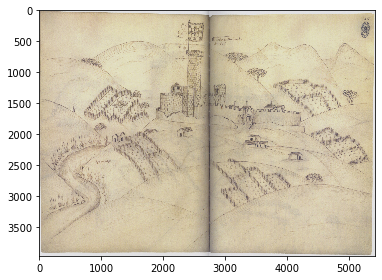

In [7]:
img = io.imread(img_path)
io.imshow(img);

In [8]:
img.shape

(3964, 5423, 3)

In [9]:
with open(ann_path,'r') as f:
    annotations = json.load(f)

In [10]:
for ii,ob in enumerate(annotations['objects']):
    print(ii, ob['id'], ob['geometryType'], end='')
    if ob['geometryType'] == 'polygon':
        print(' : exterior',len(ob['points']['exterior']),'interior',len(ob['points']['interior']))
    else:
        print('')

0 455524684 polygon : exterior 36 interior 0
1 455524879 polygon : exterior 46 interior 0
2 455525094 polygon : exterior 23 interior 0
3 455525139 polygon : exterior 16 interior 0
4 455525195 polygon : exterior 21 interior 0
5 455525319 polygon : exterior 19 interior 0
6 455525361 polygon : exterior 51 interior 0
7 455525387 polygon : exterior 115 interior 0
8 455525455 polygon : exterior 64 interior 0
9 455525565 polygon : exterior 225 interior 0
10 455525654 polygon : exterior 4 interior 0
11 455525667 polygon : exterior 9 interior 0
12 455525678 polygon : exterior 4 interior 0
13 455525686 polygon : exterior 7 interior 0
14 455525701 polygon : exterior 8 interior 0
15 455525741 bitmap
16 455525808 bitmap
17 455525835 bitmap
18 456895995 polygon : exterior 8 interior 0
19 456896102 polygon : exterior 27 interior 0
20 456896680 polygon : exterior 92 interior 0
21 456896903 polygon : exterior 85 interior 0
22 456897091 polygon : exterior 247 interior 0
23 456983070 polygon : exterior 3

In [11]:
ob = annotations['objects'][150]
ob

{'id': 457542871,
 'classId': 1521148,
 'description': '',
 'geometryType': 'polygon',
 'labelerLogin': 'edtriplett',
 'createdAt': '2020-06-05T15:34:46.288Z',
 'updatedAt': '2020-06-14T23:20:32.100Z',
 'tags': [{'id': 27891581,
   'name': '* Ruined or intact?',
   'value': 'Intact',
   'labelerLogin': 'edtriplett',
   'createdAt': '2020-06-05T15:35:50.505Z',
   'updatedAt': '2020-06-05T15:35:50.505Z'},
  {'id': 27891652,
   'name': '* Field area, fence or wall type?',
   'value': 'Field area',
   'labelerLogin': 'edtriplett',
   'createdAt': '2020-06-05T15:35:47.233Z',
   'updatedAt': '2020-06-05T15:35:47.233Z'},
  {'id': 27891801,
   'name': '* Partially occluded or Complete?',
   'value': 'Partially Occluded',
   'labelerLogin': 'edtriplett',
   'createdAt': '2020-06-05T15:35:43.286Z',
   'updatedAt': '2020-06-05T15:35:43.286Z'}],
 'classTitle': 'Fields, fences and non-fortified walls',
 'instance': '457542936',
 'points': {'exterior': [[1679, 1624],
   [1655, 1588],
   [1650, 1588]

### Just exterior points for now...

In [12]:
points = ob['points']
exterior = np.array(points['exterior'])
exterior.dtype

dtype('int64')

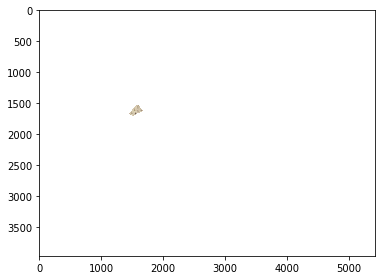

In [13]:
ww = exterior[:,0]
hh = exterior[:,1]

mask = poly2mask(hh, ww, img.shape[:2])
img_masked = np.zeros((img.shape[0],img.shape[1],4),dtype=np.uint8)
img_masked[:,:,:3] = img
img_masked[:,:,3] = (mask*255).astype('uint8')
io.imshow(img_masked)

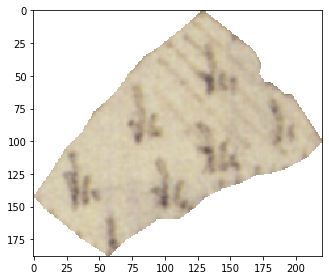

In [14]:
# To get all the way cropped should really add 1 to hh.min(). Not sure why...
crop_w = slice(ww.min(), ww.max())
crop_h = slice(hh.min()+1, hh.max())

img_cropped = img_masked[crop_h,crop_w,:]
io.imshow(img_cropped)

In [15]:
img_name = os.path.splitext(img_filename)[0]
io.imsave(os.path.join(mask_dir, img_name+'_'+str(ob['classId'])+'_'+str(ob['id'])+'.png'), img_cropped)

---

## Do the crop before creating masked image

In [16]:
exterior.min(axis=0)

array([1458, 1523])

In [17]:
exterior.max(axis=0)

array([1679, 1712])

In [18]:
(rmin,rmax),(cmin,cmax) = bbox2(mask)
print((rmin,rmax),(cmin,cmax))
print(exterior.min(axis=0).tolist(),exterior.max(axis=0).tolist())
print(crop_h,crop_w)

(1524, 1712) (1458, 1679)
[1458, 1523] [1679, 1712]
slice(1524, 1712, None) slice(1458, 1679, None)


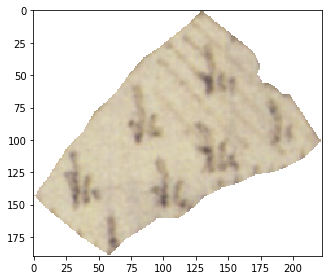

In [19]:
io.imshow(img_masked[rmin-1:rmax+1,cmin-1:cmax+1,:]);

In [20]:
img_sliced = img_masked[rmin:rmax,cmin:cmax,:]
io.imsave(os.path.join(mask_dir,img_name+'_'+str(ob['classId'])+'_'+str(ob['id'])+'_sliced.png'), img_sliced)

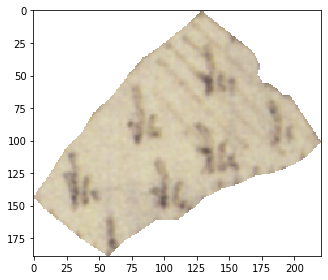

In [21]:
# (rmin,rmax),(cmin,cmax) = bbox2(mask_img[:,:,3])
# To get all the way cropped should really add 1 to rmin. Not sure why...

[cmin,rmin] = exterior.min(axis=0)
[cmax,rmax] = exterior.max(axis=0)

img_masked_sm = np.zeros((rmax-rmin,cmax-cmin,4), dtype=np.uint8)

exterior_offset = exterior - exterior.min(axis=0)

ww_sm = exterior_offset[:,0]
hh_sm = exterior_offset[:,1]
mask_sm = poly2mask(hh_sm, ww_sm, img_masked_sm.shape[:2])

img_masked_sm[:,:,:3] = img[slice(rmin,rmax), slice(cmin,cmax), :3]
img_masked_sm[:,:,3] = 255*mask_sm.astype(np.uint8)
io.imshow(img_masked_sm);

In [22]:
io.imsave(os.path.join(mask_dir,img_name+'_'+str(ob['classId'])+'_'+str(ob['id'])+'_sm.png'), img_masked_sm)